In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

def calculate_adx(df, period=14):
    # True Range
    df['TR'] = np.maximum(
        np.maximum(
            df['high'] - df['low'],
            abs(df['high'] - df['close'].shift(1))
        ),
        abs(df['low'] - df['close'].shift(1))
    )
    
    # Directional Movement
    df['DM_plus'] = np.where(
        (df['high'] - df['high'].shift(1)) > (df['low'].shift(1) - df['low']),
        np.maximum(df['high'] - df['high'].shift(1), 0),
        0
    )
    df['DM_minus'] = np.where(
        (df['low'].shift(1) - df['low']) > (df['high'] - df['high'].shift(1)),
        np.maximum(df['low'].shift(1) - df['low'], 0),
        0
    )
    
    # Smoothed TR and DM
    df['TR_smoothed'] = df['TR'].rolling(window=period).mean()
    df['DM_plus_smoothed'] = df['DM_plus'].rolling(window=period).mean()
    df['DM_minus_smoothed'] = df['DM_minus'].rolling(window=period).mean()
    
    # Directional Indicators
    df['DI_plus'] = 100 * (df['DM_plus_smoothed'] / df['TR_smoothed'])
    df['DI_minus'] = 100 * (df['DM_minus_smoothed'] / df['TR_smoothed'])
    
    # ADX
    df['DX'] = 100 * abs(df['DI_plus'] - df['DI_minus']) / (df['DI_plus'] + df['DI_minus'])
    df['ADX'] = df['DX'].rolling(window=period).mean()
    
    # ADXR
    df['ADXR'] = (df['ADX'] + df['ADX'].shift(period)) / 2
    
    return df['ADX'], df['ADXR']

def hawkes_process(series, alpha=0.1, beta=0.2, window=20):
    hawkes = pd.Series(index=series.index, dtype=float)
    intensity = 0
    
    for i in range(len(series)):
        if i > 0:
            decay = np.exp(-beta)
            intensity = intensity * decay + alpha * (series.iloc[i-1] > series.iloc[i-1:i-window:-1].mean())
        hawkes.iloc[i] = intensity
    
    return hawkes

def calculate_bollinger_bands(df, window=20, num_sd=2):
    sma = df['close'].rolling(window).mean()
    std = df['close'].rolling(window).std()
    return sma + (std * num_sd), sma - (std * num_sd)

def calculate_macd(df, fast=12, slow=26, signal=9):
    exp1 = df['close'].ewm(span=fast, adjust=False).mean()
    exp2 = df['close'].ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

def calculate_stochastic(df, k_period=14, d_period=3):
    low_min = df['low'].rolling(window=k_period).min()
    high_max = df['high'].rolling(window=k_period).max()
    k = 100 * ((df['close'] - low_min) / (high_max - low_min))
    d = k.rolling(window=d_period).mean()
    return k, d

def calculate_atr(df, window=14):
    tr1 = df['high'] - df['low']
    tr2 = abs(df['high'] - df['close'].shift(1))
    tr3 = abs(df['low'] - df['close'].shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(window).mean()

def calculate_obv(df):
    obv = [0]
    for i in range(1, len(df)):
        if df['close'].iloc[i] > df['close'].iloc[i-1]:
            obv.append(obv[-1] + df['volume'].iloc[i])
        elif df['close'].iloc[i] < df['close'].iloc[i-1]:
            obv.append(obv[-1] - df['volume'].iloc[i])
        else:
            obv.append(obv[-1])
    return pd.Series(obv, index=df.index)

def calculate_atr_percentile(df, period=14, lookback=100):
    atr = df['ATR']
    atr_percentile = atr.rolling(window=lookback).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1]
    )
    return atr_percentile

def calculate_dynamic_atr_multiplier(df, base_multiplier=2):
    volatility_factor = df['ATR_percentile'].clip(0.2, 0.8)
    return base_multiplier * (1 + volatility_factor)

def calculate_atr_bands(df, period=14):
    df['ATR_upper'] = df['close'] + (df['ATR'] * df['ATR_multiplier'])
    df['ATR_lower'] = df['close'] - (df['ATR'] * df['ATR_multiplier'])
    return df['ATR_upper'], df['ATR_lower']

def calculate_trailing_stop(df, position, entry_price, current_index, trail_points):
    if position == 1:  # Long position
        stops = entry_price - (df['ATR'].iloc[trail_points:current_index+1] * 
                             df['ATR_multiplier'].iloc[trail_points:current_index+1])
        return max(stops)
    elif position == -1:  # Short position
        stops = entry_price + (df['ATR'].iloc[trail_points:current_index+1] * 
                             df['ATR_multiplier'].iloc[trail_points:current_index+1])
        return min(stops)
    return None

def calculate_slope(series, period=5):
    # Calculate slope over the specified period
    slope = pd.Series(index=series.index, dtype=float)
    x = np.arange(period)
    
    for i in range(period-1, len(series)):
        y = series.iloc[i-period+1:i+1].values
        slope.iloc[i] = np.polyfit(x, y, 1)[0]
    
    return slope

def implement_strategy(file_path):
    # Read and process data
    df = pd.read_csv(file_path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    df = df.dropna()
    
    # Calculate indicators (same as before)
    df['BB_upper'], df['BB_lower'] = calculate_bollinger_bands(df)
    df['MACD'], df['Signal_Line'] = calculate_macd(df)
    df['Stoch_K'], df['Stoch_D'] = calculate_stochastic(df)
    df['ATR'] = calculate_atr(df)
    df['OBV'] = calculate_obv(df)
    df['ADX'], df['ADXR'] = calculate_adx(df)
    
    # Enhanced volume analysis
    df['vol_normalized'] = (df['volume'] - df['volume'].rolling(20).mean()) / df['volume'].rolling(20).std()
    df['volume_hawkes'] = hawkes_process(df['vol_normalized'])
    
    # ATR calculations
    df['ATR_percentile'] = calculate_atr_percentile(df)
    df['ATR_multiplier'] = calculate_dynamic_atr_multiplier(df, base_multiplier=1.5)  # Reduced multiplier
    df['ATR_upper'], df['ATR_lower'] = calculate_atr_bands(df)
    
    # New trend indicators
    df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
    df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()
    df['RSI'] = calculate_rsi(df['close'], 14)
    
    # Calculate slopes
    df['MACD_slope'] = calculate_slope(df['MACD'])
    df['ADX_slope'] = calculate_slope(df['ADX'])
    df['OBV_slope'] = calculate_slope(df['OBV'])
    
    position = 0
    portfolio = 1000
    trades = []
    entry_price = 0
    last_trade_index = 0
    min_bars_between_trades = 2  # Reduced waiting time
    trailing_stop = None
    
    # Trading loop
    for i in range(len(df)):
        if i < 50 or df.iloc[i].isnull().any():
            continue
            
        if i - last_trade_index < min_bars_between_trades:
            continue
            
        current_price = df['close'].iloc[i]
        
        # Enhanced trend conditions
        strong_trend = df['ADX'].iloc[i] > 20  # Lowered threshold
        trend_improving = df['ADXR'].iloc[i] > df['ADX'].iloc[i]
        ema_trend = df['EMA_20'].iloc[i] > df['EMA_50'].iloc[i]
        
        positive_slopes = (
            df['MACD_slope'].iloc[i] > 0 and
            df['OBV_slope'].iloc[i] > 0
        )
        negative_slopes = (
            df['MACD_slope'].iloc[i] < 0 and
            df['OBV_slope'].iloc[i] < 0
        )
        
        volume_spike = df['volume_hawkes'].iloc[i] > 0
        
        # Enhanced entry conditions
        long_condition = (
            (strong_trend or ema_trend) and
            positive_slopes and
            volume_spike and
            df['close'].iloc[i] <= df['BB_lower'].iloc[i] and
            df['MACD'].iloc[i] > df['Signal_Line'].iloc[i] and
            df['Stoch_K'].iloc[i] < 35 and  # Increased threshold
            df['RSI'].iloc[i] < 40  # New RSI condition
        )
        
        short_condition = (
            (strong_trend or not ema_trend) and
            negative_slopes and
            volume_spike and
            df['close'].iloc[i] >= df['BB_upper'].iloc[i] and
            df['MACD'].iloc[i] < df['Signal_Line'].iloc[i] and
            df['Stoch_K'].iloc[i] > 65 and  # Decreased threshold
            df['RSI'].iloc[i] > 60  # New RSI condition
        )
        
        # Position sizing based on volatility
        position_size = 1.0
        if df['ATR_percentile'].iloc[i] < 0.3:
            position_size = 1.5  # Increase position size in low volatility
        
        if position == 0:
            if long_condition:
                position = 1
                entry_price = current_price
                trailing_stop = current_price - (df['ATR'].iloc[i] * df['ATR_multiplier'].iloc[i])
                portfolio *= (1 - 0.001)
                trades.append(('LONG', df.index[i], entry_price, portfolio))
                last_trade_index = i
            elif short_condition:
                position = -1
                entry_price = current_price
                trailing_stop = current_price + (df['ATR'].iloc[i] * df['ATR_multiplier'].iloc[i])
                portfolio *= (1 - 0.001)
                trades.append(('SHORT', df.index[i], entry_price, portfolio))
                last_trade_index = i
        
        elif position == 1:
            new_stop = calculate_trailing_stop(df, position, entry_price, i, last_trade_index)
            trailing_stop = max(trailing_stop, new_stop) if trailing_stop else new_stop
            
            # Enhanced exit conditions
            stop_hit = current_price < trailing_stop
            rsi_overbought = df['RSI'].iloc[i] > 70
            
            if short_condition or stop_hit or rsi_overbought:
                position = 0
                exit_price = current_price
                portfolio *= (1 - 0.001) * (exit_price / entry_price) * position_size
                trades.append(('EXIT_LONG', df.index[i], exit_price, portfolio))
                last_trade_index = i
                trailing_stop = None
                
        elif position == -1:
            new_stop = calculate_trailing_stop(df, position, entry_price, i, last_trade_index)
            trailing_stop = min(trailing_stop, new_stop) if trailing_stop else new_stop
            
            # Enhanced exit conditions
            stop_hit = current_price > trailing_stop
            rsi_oversold = df['RSI'].iloc[i] < 30
            
            if long_condition or stop_hit or rsi_oversold:
                position = 0
                exit_price = current_price
                portfolio *= (1 - 0.001) * (2 - exit_price / entry_price) * position_size
                trades.append(('EXIT_SHORT', df.index[i], exit_price, portfolio))
                last_trade_index = i
                trailing_stop = None
    
    trades_df = pd.DataFrame(trades, columns=['Type', 'DateTime', 'Price', 'Portfolio'])
    
    if len(trades_df) > 0:
        market_return = (df['close'].iloc[-1] / df['close'].iloc[0] - 1) * 100
        strategy_return = (portfolio / 1000 - 1) * 100
        
        peak = trades_df['Portfolio'].expanding(min_periods=1).max()
        drawdown = (trades_df['Portfolio'] - peak) / peak
        max_drawdown = drawdown.min() * 100
        
        returns = trades_df['Portfolio'].pct_change()
        sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std()) if len(returns) > 1 else 0
        
        profitable_trades = sum(trades_df['Portfolio'].diff() > 0)
        win_rate = (profitable_trades / len(trades_df)) * 100
        
        print(f"Performance Metrics:")
        print(f"Total Return: {strategy_return:.2f}% (Market: {market_return:.2f}%)")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Win Rate: {win_rate:.2f}%")
        print(f"Number of Trades: {len(trades_df)}")
    
    return trades_df

def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

if __name__ == "__main__":
    file_path = "BTC_2019_2023_3m.csv"
    trades_df = implement_strategy(file_path)

Performance Metrics:
Total Return: 36.54% (Market: 324.58%)
Max Drawdown: -5.87%
Sharpe Ratio: 3.35
Win Rate: 12.50%
Number of Trades: 16


with euity curve, trades plot and dropdown plot

C:\Users\sp_kr\AppData\Local\Temp\ipykernel_8516\1026488166.py:331: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  equity_df['equity'] = equity_df['equity'].ffill()
C:\Users\sp_kr\AppData\Local\Temp\ipykernel_8516\1026488166.py:343: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  equity_df['equity'] = equity_df['equity'].fillna(method='ffill')


Performance Metrics:
Total Return: 4347938983.78% (Market: 323.32%)
Max Drawdown: -3.05%
Sharpe Ratio: 7.42
Win Rate: 27.50%
Number of Trades: 240
Calmar Ratio: 1426403953.55
Annualized Return: 0.20%


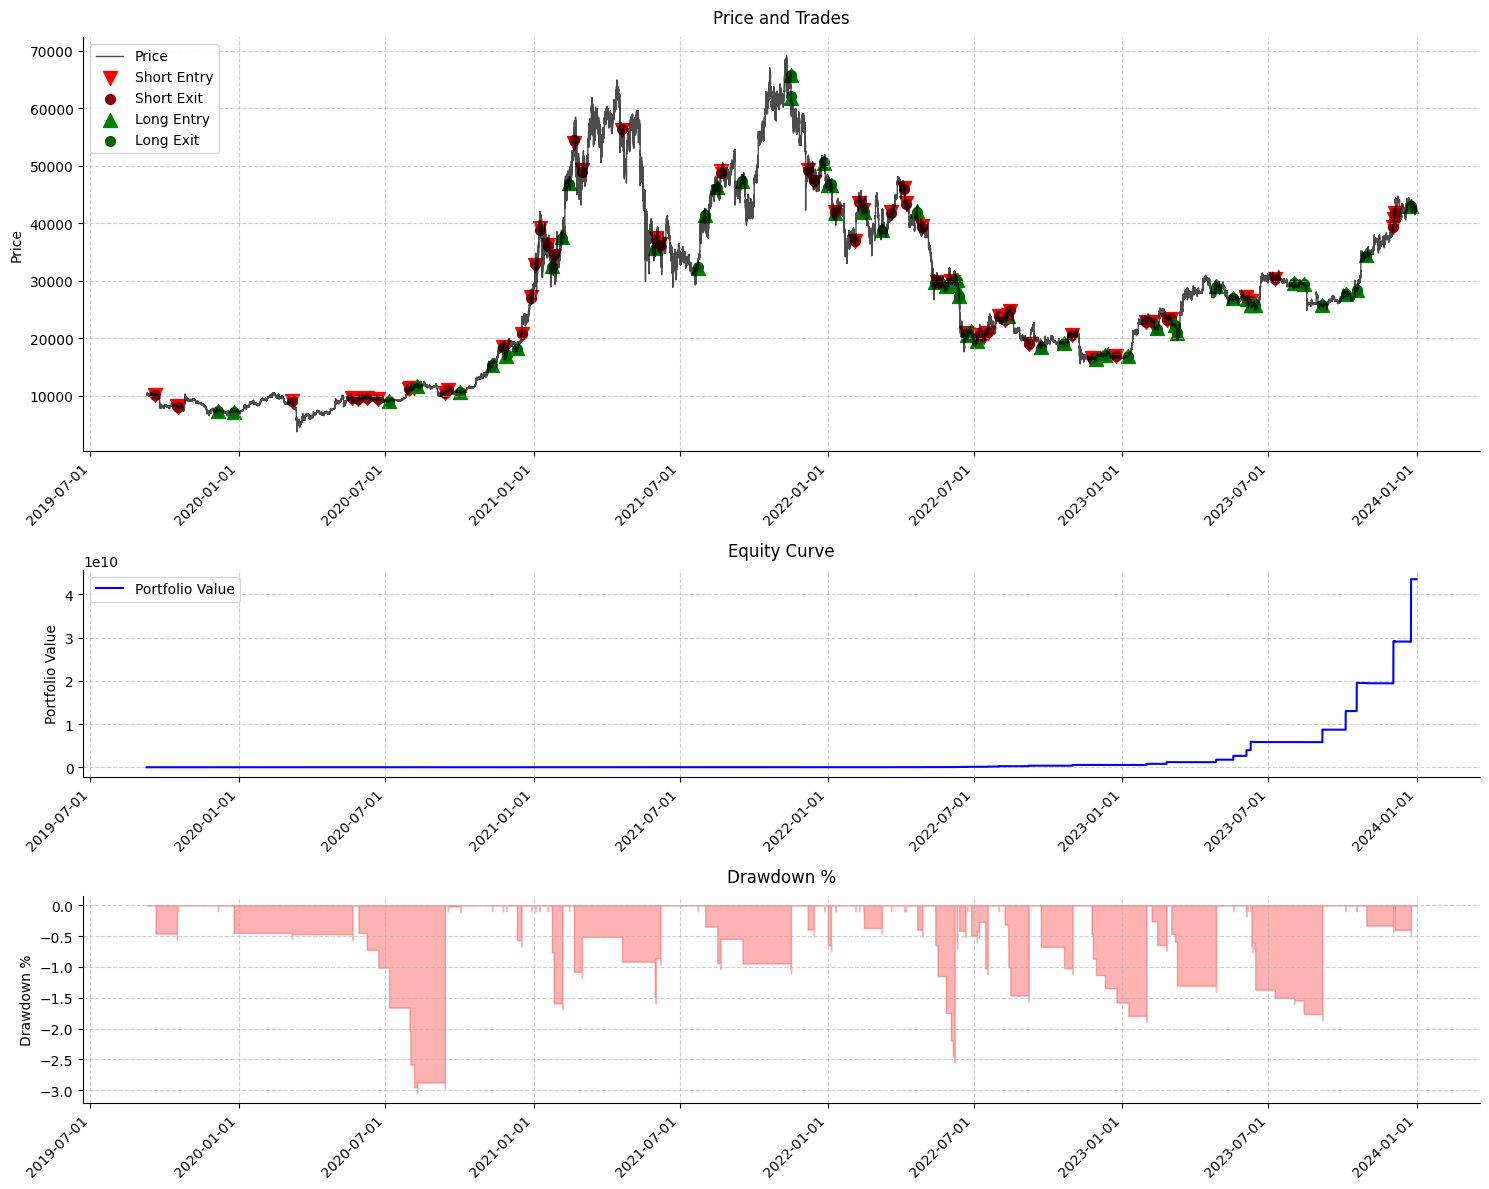

In [9]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

def calculate_adx(df, period=14):
    df['TR'] = np.maximum(
        np.maximum(
            df['high'] - df['low'],
            abs(df['high'] - df['close'].shift(1))
        ),
        abs(df['low'] - df['close'].shift(1))
    )
    
    df['DM_plus'] = np.where(
        (df['high'] - df['high'].shift(1)) > (df['low'].shift(1) - df['low']),
        np.maximum(df['high'] - df['high'].shift(1), 0),
        0
    )
    df['DM_minus'] = np.where(
        (df['low'].shift(1) - df['low']) > (df['high'] - df['high'].shift(1)),
        np.maximum(df['low'].shift(1) - df['low'], 0),
        0
    )
    
    df['TR_smoothed'] = df['TR'].rolling(window=period).mean()
    df['DM_plus_smoothed'] = df['DM_plus'].rolling(window=period).mean()
    df['DM_minus_smoothed'] = df['DM_minus'].rolling(window=period).mean()
    
    df['DI_plus'] = 100 * (df['DM_plus_smoothed'] / df['TR_smoothed'])
    df['DI_minus'] = 100 * (df['DM_minus_smoothed'] / df['TR_smoothed'])
    
    df['DX'] = 100 * abs(df['DI_plus'] - df['DI_minus']) / (df['DI_plus'] + df['DI_minus'])
    df['ADX'] = df['DX'].rolling(window=period).mean()
    df['ADXR'] = (df['ADX'] + df['ADX'].shift(period)) / 2
    
    return df['ADX'], df['ADXR']

def hawkes_process(series, alpha=0.1, beta=0.2, window=20):
    hawkes = pd.Series(index=series.index, dtype=float)
    intensity = 0
    
    for i in range(len(series)):
        if i > 0:
            decay = np.exp(-beta)
            intensity = intensity * decay + alpha * (series.iloc[i-1] > series.iloc[i-1:i-window:-1].mean())
        hawkes.iloc[i] = intensity
    
    return hawkes

def calculate_bollinger_bands(df, window=20, num_sd=2):
    sma = df['close'].rolling(window).mean()
    std = df['close'].rolling(window).std()
    return sma + (std * num_sd), sma - (std * num_sd)

def calculate_macd(df, fast=12, slow=26, signal=9):
    exp1 = df['close'].ewm(span=fast, adjust=False).mean()
    exp2 = df['close'].ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

def calculate_stochastic(df, k_period=14, d_period=3):
    low_min = df['low'].rolling(window=k_period).min()
    high_max = df['high'].rolling(window=k_period).max()
    k = 100 * ((df['close'] - low_min) / (high_max - low_min))
    d = k.rolling(window=d_period).mean()
    return k, d

def calculate_atr(df, window=14):
    tr1 = df['high'] - df['low']
    tr2 = abs(df['high'] - df['close'].shift(1))
    tr3 = abs(df['low'] - df['close'].shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(window).mean()

def calculate_obv(df):
    obv = [0]
    for i in range(1, len(df)):
        if df['close'].iloc[i] > df['close'].iloc[i-1]:
            obv.append(obv[-1] + df['volume'].iloc[i])
        elif df['close'].iloc[i] < df['close'].iloc[i-1]:
            obv.append(obv[-1] - df['volume'].iloc[i])
        else:
            obv.append(obv[-1])
    return pd.Series(obv, index=df.index)

def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_atr_percentile(df, period=14, lookback=100):
    atr = df['ATR']
    atr_percentile = atr.rolling(window=lookback).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1]
    )
    return atr_percentile

def calculate_dynamic_atr_multiplier(df, base_multiplier=2):
    volatility_factor = df['ATR_percentile'].clip(0.2, 0.8)
    return base_multiplier * (1 + volatility_factor)

def calculate_atr_bands(df, period=14):
    df['ATR_upper'] = df['close'] + (df['ATR'] * df['ATR_multiplier'])
    df['ATR_lower'] = df['close'] - (df['ATR'] * df['ATR_multiplier'])
    return df['ATR_upper'], df['ATR_lower']

def calculate_trailing_stop(df, position, entry_price, current_index, trail_points):
    if position == 1:
        stops = entry_price - (df['ATR'].iloc[trail_points:current_index+1] * 
                             df['ATR_multiplier'].iloc[trail_points:current_index+1])
        return max(stops)
    elif position == -1:
        stops = entry_price + (df['ATR'].iloc[trail_points:current_index+1] * 
                             df['ATR_multiplier'].iloc[trail_points:current_index+1])
        return min(stops)
    return None

def calculate_slope(series, period=5):
    slope = pd.Series(index=series.index, dtype=float)
    x = np.arange(period)
    
    for i in range(period-1, len(series)):
        y = series.iloc[i-period+1:i+1].values
        slope.iloc[i] = np.polyfit(x, y, 1)[0]
    
    return slope

def plot_strategy_results(df, trades_df, equity_df):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), height_ratios=[2, 1, 1])
    
    # Price and trades plot
    ax1.plot(df.index, df['close'], label='Price', color='black', alpha=0.7, linewidth=1)
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Plot trades
    for _, trade in trades_df.iterrows():
        if trade['Type'] == 'LONG':
            ax1.scatter(trade['DateTime'], trade['Price'], color='green', marker='^', s=100, label='Long Entry')
        elif trade['Type'] == 'SHORT':
            ax1.scatter(trade['DateTime'], trade['Price'], color='red', marker='v', s=100, label='Short Entry')
        elif trade['Type'] == 'EXIT_LONG':
            ax1.scatter(trade['DateTime'], trade['Price'], color='darkgreen', marker='o', s=50, label='Long Exit')
        elif trade['Type'] == 'EXIT_SHORT':
            ax1.scatter(trade['DateTime'], trade['Price'], color='darkred', marker='o', s=50, label='Short Exit')
    
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys(), loc='upper left')
    ax1.set_title('Price and Trades', fontsize=12, pad=10)
    ax1.set_ylabel('Price', fontsize=10)
    
    # Equity curve
    ax2.plot(equity_df.index, equity_df['equity'], label='Portfolio Value', color='blue', linewidth=1.5)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend(loc='upper left')
    ax2.set_title('Equity Curve', fontsize=12, pad=10)
    ax2.set_ylabel('Portfolio Value', fontsize=10)
    
    # Drawdown
    drawdown = (equity_df['equity'] - equity_df['equity'].cummax()) / equity_df['equity'].cummax() * 100
    ax3.fill_between(drawdown.index, drawdown.values, 0, color='red', alpha=0.3)
    ax3.grid(True, linestyle='--', alpha=0.6)
    ax3.set_title('Drawdown %', fontsize=12, pad=10)
    ax3.set_ylabel('Drawdown %', fontsize=10)
    
    # Format dates
    date_formatter = DateFormatter("%Y-%m-%d")
    for ax in [ax1, ax2, ax3]:
        ax.xaxis.set_major_formatter(date_formatter)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    return fig

def implement_strategy(file_path):
    df = pd.read_csv(file_path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    df = df.dropna()
    
    df['BB_upper'], df['BB_lower'] = calculate_bollinger_bands(df)
    df['MACD'], df['Signal_Line'] = calculate_macd(df)
    df['Stoch_K'], df['Stoch_D'] = calculate_stochastic(df)
    df['ATR'] = calculate_atr(df)
    df['OBV'] = calculate_obv(df)
    df['ADX'], df['ADXR'] = calculate_adx(df)
    
    df['vol_normalized'] = (df['volume'] - df['volume'].rolling(20).mean()) / df['volume'].rolling(20).std()
    df['volume_hawkes'] = hawkes_process(df['vol_normalized'])
    
    df['ATR_percentile'] = calculate_atr_percentile(df)
    df['ATR_multiplier'] = calculate_dynamic_atr_multiplier(df, base_multiplier=1.5)
    df['ATR_upper'], df['ATR_lower'] = calculate_atr_bands(df)
    
    df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
    df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()
    df['RSI'] = calculate_rsi(df['close'], 14)
    
    df['MACD_slope'] = calculate_slope(df['MACD'])
    df['ADX_slope'] = calculate_slope(df['ADX'])
    df['OBV_slope'] = calculate_slope(df['OBV'])
    
    position = 0
    portfolio = 1000
    trades = []
    entry_price = 0
    last_trade_index = 0
    min_bars_between_trades = 2
    trailing_stop = None
    
    # Trading loop (same as before)
    for i in range(len(df)):
        if i < 50 or df.iloc[i].isnull().any():
            continue
            
        if i - last_trade_index < min_bars_between_trades:
            continue
            
        current_price = df['close'].iloc[i]
        
        strong_trend = df['ADX'].iloc[i] > 20
        trend_improving = df['ADXR'].iloc[i] > df['ADX'].iloc[i]
        ema_trend = df['EMA_20'].iloc[i] > df['EMA_50'].iloc[i]
        
        positive_slopes = (
            df['MACD_slope'].iloc[i] > 0 and
            df['OBV_slope'].iloc[i] > 0
        )
        negative_slopes = (
            df['MACD_slope'].iloc[i] < 0 and
            df['OBV_slope'].iloc[i] < 0
        )
        
        volume_spike = df['volume_hawkes'].iloc[i] > 0
        
        long_condition = (
            (strong_trend or ema_trend) and
            positive_slopes and
            volume_spike and
            df['close'].iloc[i] <= df['BB_lower'].iloc[i] and
            df['MACD'].iloc[i] > df['Signal_Line'].iloc[i] and
            df['Stoch_K'].iloc[i] < 35 and
            df['RSI'].iloc[i] < 40
        )
        
        short_condition = (
            (strong_trend or not ema_trend) and
            negative_slopes and
            volume_spike and
            df['close'].iloc[i] >= df['BB_upper'].iloc[i] and
            df['MACD'].iloc[i] < df['Signal_Line'].iloc[i] and
            df['Stoch_K'].iloc[i] > 65 and
            df['RSI'].iloc[i] > 60
        )
        
        position_size = 1.0
        if df['ATR_percentile'].iloc[i] < 0.3:
            position_size = 1.5
        
        if position == 0:
            if long_condition:
                position = 1
                entry_price = current_price
                trailing_stop = current_price - (df['ATR'].iloc[i] * df['ATR_multiplier'].iloc[i])
                portfolio *= (1 - 0.001)
                trades.append(('LONG', df.index[i], entry_price, portfolio))
                last_trade_index = i
            elif short_condition:
                position = -1
                entry_price = current_price
                trailing_stop = current_price + (df['ATR'].iloc[i] * df['ATR_multiplier'].iloc[i])
                portfolio *= (1 - 0.001)
                trades.append(('SHORT', df.index[i], entry_price, portfolio))
                last_trade_index = i
        
        elif position == 1:
            new_stop = calculate_trailing_stop(df, position, entry_price, i, last_trade_index)
            trailing_stop = max(trailing_stop, new_stop) if trailing_stop else new_stop
            
            stop_hit = current_price < trailing_stop
            rsi_overbought = df['RSI'].iloc[i] > 70
            
            if short_condition or stop_hit or rsi_overbought:
                position = 0
                exit_price = current_price
                portfolio *= (1 - 0.001) * (exit_price / entry_price) * position_size
                trades.append(('EXIT_LONG', df.index[i], exit_price, portfolio))
                last_trade_index = i
                trailing_stop = None
                
        elif position == -1:
            new_stop = calculate_trailing_stop(df, position, entry_price, i, last_trade_index)
            trailing_stop = min(trailing_stop, new_stop) if trailing_stop else new_stop
            
            stop_hit = current_price > trailing_stop
            rsi_oversold = df['RSI'].iloc[i] < 30
            
            if long_condition or stop_hit or rsi_oversold:
                position = 0
                exit_price = current_price
                portfolio *= (1 - 0.001) * (2 - exit_price / entry_price) * position_size
                trades.append(('EXIT_SHORT', df.index[i], exit_price, portfolio))
                last_trade_index = i
                trailing_stop = None
    
    trades_df = pd.DataFrame(trades, columns=['Type', 'DateTime', 'Price', 'Portfolio'])
    
    # Calculate equity curve
    equity_df = pd.DataFrame(index=df.index)
    equity_df['equity'] = None
    initial_portfolio = 1000
    current_portfolio = initial_portfolio
    
    for i in range(len(df)):
        current_datetime = df.index[i]
        trades_at_time = trades_df[trades_df['DateTime'] == current_datetime]
        
        if not trades_at_time.empty:
            current_portfolio = trades_at_time.iloc[-1]['Portfolio']
            
        equity_df.loc[current_datetime, 'equity'] = current_portfolio
    
    # Fixed fillna deprecation warning
    equity_df['equity'] = equity_df['equity'].ffill()
    equity_df['equity'] = equity_df['equity'].fillna(value=initial_portfolio)
    
    if len(trades_df) > 0:
        current_datetime = df.index[i]
        trades_at_time = trades_df[trades_df['DateTime'] == current_datetime]
        
        if not trades_at_time.empty:
            current_portfolio = trades_at_time.iloc[-1]['Portfolio']
            
        equity_df.loc[current_datetime, 'equity'] = current_portfolio
    
    equity_df['equity'] = equity_df['equity'].fillna(method='ffill')
    equity_df['equity'] = equity_df['equity'].fillna(initial_portfolio)
    
    if len(trades_df) > 0:
        market_return = (df['close'].iloc[-1] / df['close'].iloc[0] - 1) * 100
        strategy_return = (portfolio / 1000 - 1) * 100
        
        peak = trades_df['Portfolio'].expanding(min_periods=1).max()
        drawdown = (trades_df['Portfolio'] - peak) / peak
        max_drawdown = drawdown.min() * 100
        
        returns = trades_df['Portfolio'].pct_change()
        sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std()) if len(returns) > 1 else 0
        
        profitable_trades = sum(trades_df['Portfolio'].diff() > 0)
        win_rate = (profitable_trades / len(trades_df)) * 100
        
        calmar_ratio = abs(strategy_return / max_drawdown) if max_drawdown != 0 else 0
        annual_return = (1 + strategy_return/100) ** (252/len(df)) - 1
        
        print(f"Performance Metrics:")
        print(f"Total Return: {strategy_return:.2f}% (Market: {market_return:.2f}%)")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Win Rate: {win_rate:.2f}%")
        print(f"Number of Trades: {len(trades_df)}")
        print(f"Calmar Ratio: {calmar_ratio:.2f}")
        print(f"Annualized Return: {annual_return*100:.2f}%")
        
        # Create and save the plot
        fig = plot_strategy_results(df, trades_df, equity_df)
        plt.savefig('strategy_results_1m.png', dpi=300, bbox_inches='tight')
        plt.show()  # Add this line to display the plot
        plt.close()
    
    return trades_df, equity_df

if __name__ == "__main__":
    file_path = "BTC_2019_2023_1m.csv"
    trades_df, equity_df = implement_strategy(file_path)

with graphs and fees tracking

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

def calculate_adx(df, period=14):
    df['TR'] = np.maximum(
        np.maximum(
            df['high'] - df['low'],
            abs(df['high'] - df['close'].shift(1))
        ),
        abs(df['low'] - df['close'].shift(1))
    )
    
    df['DM_plus'] = np.where(
        (df['high'] - df['high'].shift(1)) > (df['low'].shift(1) - df['low']),
        np.maximum(df['high'] - df['high'].shift(1), 0),
        0
    )
    df['DM_minus'] = np.where(
        (df['low'].shift(1) - df['low']) > (df['high'] - df['high'].shift(1)),
        np.maximum(df['low'].shift(1) - df['low'], 0),
        0
    )
    
    df['TR_smoothed'] = df['TR'].rolling(window=period).mean()
    df['DM_plus_smoothed'] = df['DM_plus'].rolling(window=period).mean()
    df['DM_minus_smoothed'] = df['DM_minus'].rolling(window=period).mean()
    
    df['DI_plus'] = 100 * (df['DM_plus_smoothed'] / df['TR_smoothed'])
    df['DI_minus'] = 100 * (df['DM_minus_smoothed'] / df['TR_smoothed'])
    
    df['DX'] = 100 * abs(df['DI_plus'] - df['DI_minus']) / (df['DI_plus'] + df['DI_minus'])
    df['ADX'] = df['DX'].rolling(window=period).mean()
    df['ADXR'] = (df['ADX'] + df['ADX'].shift(period)) / 2
    
    return df['ADX'], df['ADXR']

def hawkes_process(series, alpha=0.1, beta=0.2, window=20):
    hawkes = pd.Series(index=series.index, dtype=float)
    intensity = 0
    
    for i in range(len(series)):
        if i > 0:
            decay = np.exp(-beta)
            intensity = intensity * decay + alpha * (series.iloc[i-1] > series.iloc[i-1:i-window:-1].mean())
        hawkes.iloc[i] = intensity
    
    return hawkes

def calculate_bollinger_bands(df, window=20, num_sd=2):
    sma = df['close'].rolling(window).mean()
    std = df['close'].rolling(window).std()
    return sma + (std * num_sd), sma - (std * num_sd)

def calculate_macd(df, fast=12, slow=26, signal=9):
    exp1 = df['close'].ewm(span=fast, adjust=False).mean()
    exp2 = df['close'].ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

def calculate_stochastic(df, k_period=14, d_period=3):
    low_min = df['low'].rolling(window=k_period).min()
    high_max = df['high'].rolling(window=k_period).max()
    k = 100 * ((df['close'] - low_min) / (high_max - low_min))
    d = k.rolling(window=d_period).mean()
    return k, d

def calculate_atr(df, window=14):
    tr1 = df['high'] - df['low']
    tr2 = abs(df['high'] - df['close'].shift(1))
    tr3 = abs(df['low'] - df['close'].shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(window).mean()

def calculate_obv(df):
    obv = [0]
    for i in range(1, len(df)):
        if df['close'].iloc[i] > df['close'].iloc[i-1]:
            obv.append(obv[-1] + df['volume'].iloc[i])
        elif df['close'].iloc[i] < df['close'].iloc[i-1]:
            obv.append(obv[-1] - df['volume'].iloc[i])
        else:
            obv.append(obv[-1])
    return pd.Series(obv, index=df.index)

def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_atr_percentile(df, period=14, lookback=100):
    atr = df['ATR']
    atr_percentile = atr.rolling(window=lookback).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1]
    )
    return atr_percentile

def calculate_dynamic_atr_multiplier(df, base_multiplier=2):
    volatility_factor = df['ATR_percentile'].clip(0.2, 0.8)
    return base_multiplier * (1 + volatility_factor)

def calculate_atr_bands(df, period=14):
    df['ATR_upper'] = df['close'] + (df['ATR'] * df['ATR_multiplier'])
    df['ATR_lower'] = df['close'] - (df['ATR'] * df['ATR_multiplier'])
    return df['ATR_upper'], df['ATR_lower']

def calculate_trailing_stop(df, position, entry_price, current_index, trail_points):
    if position == 1:
        stops = entry_price - (df['ATR'].iloc[trail_points:current_index+1] * 
                             df['ATR_multiplier'].iloc[trail_points:current_index+1])
        return max(stops)
    elif position == -1:
        stops = entry_price + (df['ATR'].iloc[trail_points:current_index+1] * 
                             df['ATR_multiplier'].iloc[trail_points:current_index+1])
        return min(stops)
    return None

def calculate_slope(series, period=5):
    slope = pd.Series(index=series.index, dtype=float)
    x = np.arange(period)
    
    for i in range(period-1, len(series)):
        y = series.iloc[i-period+1:i+1].values
        slope.iloc[i] = np.polyfit(x, y, 1)[0]
    
    return slope

def plot_strategy_results(df, trades_df, equity_df):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), height_ratios=[2, 1, 1])
    
    # Price and trades plot
    ax1.plot(df.index, df['close'], label='Price', color='black', alpha=0.7, linewidth=1)
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Plot trades
    for _, trade in trades_df.iterrows():
        if trade['Type'] == 'LONG':
            ax1.scatter(trade['DateTime'], trade['Price'], color='green', marker='^', s=100, label='Long Entry')
        elif trade['Type'] == 'SHORT':
            ax1.scatter(trade['DateTime'], trade['Price'], color='red', marker='v', s=100, label='Short Entry')
        elif trade['Type'] == 'EXIT_LONG':
            ax1.scatter(trade['DateTime'], trade['Price'], color='darkgreen', marker='o', s=50, label='Long Exit')
        elif trade['Type'] == 'EXIT_SHORT':
            ax1.scatter(trade['DateTime'], trade['Price'], color='darkred', marker='o', s=50, label='Short Exit')
    
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys(), loc='upper left')
    ax1.set_title('Price and Trades', fontsize=12, pad=10)
    ax1.set_ylabel('Price', fontsize=10)
    
    # Equity curve
    ax2.plot(equity_df.index, equity_df['equity'], label='Portfolio Value', color='blue', linewidth=1.5)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend(loc='upper left')
    ax2.set_title('Equity Curve', fontsize=12, pad=10)
    ax2.set_ylabel('Portfolio Value', fontsize=10)
    
    # Drawdown
    drawdown = (equity_df['equity'] - equity_df['equity'].cummax()) / equity_df['equity'].cummax() * 100
    ax3.fill_between(drawdown.index, drawdown.values, 0, color='red', alpha=0.3)
    ax3.grid(True, linestyle='--', alpha=0.6)
    ax3.set_title('Drawdown %', fontsize=12, pad=10)
    ax3.set_ylabel('Drawdown %', fontsize=10)
    
    # Format dates
    date_formatter = DateFormatter("%Y-%m-%d")
    for ax in [ax1, ax2, ax3]:
        ax.xaxis.set_major_formatter(date_formatter)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    return fig

def implement_strategy(file_path):
    df = pd.read_csv(file_path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    df = df.dropna()
    
    df['BB_upper'], df['BB_lower'] = calculate_bollinger_bands(df)
    df['MACD'], df['Signal_Line'] = calculate_macd(df)
    df['Stoch_K'], df['Stoch_D'] = calculate_stochastic(df)
    df['ATR'] = calculate_atr(df)
    df['OBV'] = calculate_obv(df)
    df['ADX'], df['ADXR'] = calculate_adx(df)
    
    df['vol_normalized'] = (df['volume'] - df['volume'].rolling(20).mean()) / df['volume'].rolling(20).std()
    df['volume_hawkes'] = hawkes_process(df['vol_normalized'])
    
    df['ATR_percentile'] = calculate_atr_percentile(df)
    df['ATR_multiplier'] = calculate_dynamic_atr_multiplier(df, base_multiplier=1.5)
    df['ATR_upper'], df['ATR_lower'] = calculate_atr_bands(df)
    
    df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
    df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()
    df['RSI'] = calculate_rsi(df['close'], 14)
    
    df['MACD_slope'] = calculate_slope(df['MACD'])
    df['ADX_slope'] = calculate_slope(df['ADX'])
    df['OBV_slope'] = calculate_slope(df['OBV'])
    
    position = 0
    portfolio = 1000
    trades = []
    entry_price = 0
    last_trade_index = 0
    min_bars_between_trades = 2
    trailing_stop = None
    total_fees = 0  # Initialize total fees tracker

    
    # Trading loop (same as before)
    for i in range(len(df)):
        if i < 50 or df.iloc[i].isnull().any():
            continue
            
        if i - last_trade_index < min_bars_between_trades:
            continue
            
        current_price = df['close'].iloc[i]
        
        strong_trend = df['ADX'].iloc[i] > 20
        trend_improving = df['ADXR'].iloc[i] > df['ADX'].iloc[i]
        ema_trend = df['EMA_20'].iloc[i] > df['EMA_50'].iloc[i]
        
        positive_slopes = (
            df['MACD_slope'].iloc[i] > 0 and
            df['OBV_slope'].iloc[i] > 0
        )
        negative_slopes = (
            df['MACD_slope'].iloc[i] < 0 and
            df['OBV_slope'].iloc[i] < 0
        )
        
        volume_spike = df['volume_hawkes'].iloc[i] > 0
        
        long_condition = (
            (strong_trend or ema_trend) and
            positive_slopes and
            volume_spike and
            df['close'].iloc[i] <= df['BB_lower'].iloc[i] and
            df['MACD'].iloc[i] > df['Signal_Line'].iloc[i] and
            df['Stoch_K'].iloc[i] < 35 and
            df['RSI'].iloc[i] < 40
        )
        
        short_condition = (
            (strong_trend or not ema_trend) and
            negative_slopes and
            volume_spike and
            df['close'].iloc[i] >= df['BB_upper'].iloc[i] and
            df['MACD'].iloc[i] < df['Signal_Line'].iloc[i] and
            df['Stoch_K'].iloc[i] > 65 and
            df['RSI'].iloc[i] > 60
        )
        
        position_size = 1.0
        if df['ATR_percentile'].iloc[i] < 0.3:
            position_size = 1.5
        
        if position == 0:
            if long_condition:
                position = 1
                entry_price = current_price
                trailing_stop = current_price - (df['ATR'].iloc[i] * df['ATR_multiplier'].iloc[i])
                fee = portfolio * 0.001  # Calculate fee
                total_fees += fee  # Add to total fees                
                portfolio *= (1 - 0.001)
                trades.append(('LONG', df.index[i], entry_price, portfolio, fee))  # Added fee
                last_trade_index = i
            elif short_condition:
                position = -1
                entry_price = current_price
                trailing_stop = current_price + (df['ATR'].iloc[i] * df['ATR_multiplier'].iloc[i])
                fee = portfolio * 0.001  # Calculate fee
                total_fees += fee  # Add to total fees                
                portfolio *= (1 - 0.001)
                trades.append(('SHORT', df.index[i], entry_price, portfolio, fee))  # Added fee
                last_trade_index = i
        
        elif position == 1:
            new_stop = calculate_trailing_stop(df, position, entry_price, i, last_trade_index)
            trailing_stop = max(trailing_stop, new_stop) if trailing_stop else new_stop
            
            stop_hit = current_price < trailing_stop
            rsi_overbought = df['RSI'].iloc[i] > 70
            
            if short_condition or stop_hit or rsi_overbought:
                position = 0
                exit_price = current_price
                pre_fee_portfolio = portfolio * (exit_price / entry_price) * position_size
                fee = pre_fee_portfolio * 0.001  # Calculate fee
                total_fees += fee  # Add to total fees
                portfolio = pre_fee_portfolio * (1 - 0.001)                
                trades.append(('EXIT_LONG', df.index[i], exit_price, portfolio, fee))  # Added fee
                last_trade_index = i
                trailing_stop = None
                
        elif position == -1:
            new_stop = calculate_trailing_stop(df, position, entry_price, i, last_trade_index)
            trailing_stop = min(trailing_stop, new_stop) if trailing_stop else new_stop
            
            stop_hit = current_price > trailing_stop
            rsi_oversold = df['RSI'].iloc[i] < 30
            
            if long_condition or stop_hit or rsi_oversold:
                position = 0
                exit_price = current_price
                pre_fee_portfolio = portfolio * (2 - exit_price / entry_price) * position_size
                fee = pre_fee_portfolio * 0.001  # Calculate fee
                total_fees += fee  # Add to total fees
                portfolio = pre_fee_portfolio * (1 - 0.001)                
                trades.append(('EXIT_SHORT', df.index[i], exit_price, portfolio, fee))  # Added fee
                last_trade_index = i
                trailing_stop = None
    
    trades_df = pd.DataFrame(trades, columns=['Type', 'DateTime', 'Price', 'Portfolio','Fee'])
    
    # Calculate equity curve
    equity_df = pd.DataFrame(index=df.index)
    equity_df['equity'] = None
    initial_portfolio = 1000
    current_portfolio = initial_portfolio
    
    for i in range(len(df)):
        current_datetime = df.index[i]
        trades_at_time = trades_df[trades_df['DateTime'] == current_datetime]
        
        if not trades_at_time.empty:
            current_portfolio = trades_at_time.iloc[-1]['Portfolio']
            
        equity_df.loc[current_datetime, 'equity'] = current_portfolio
    
    # Fixed fillna deprecation warning
    equity_df['equity'] = equity_df['equity'].ffill()
    equity_df['equity'] = equity_df['equity'].fillna(value=initial_portfolio)
    
    if len(trades_df) > 0:
        current_datetime = df.index[i]
        trades_at_time = trades_df[trades_df['DateTime'] == current_datetime]
        
        if not trades_at_time.empty:
            current_portfolio = trades_at_time.iloc[-1]['Portfolio']
            
        equity_df.loc[current_datetime, 'equity'] = current_portfolio
    
    equity_df['equity'] = equity_df['equity'].fillna(method='ffill')
    equity_df['equity'] = equity_df['equity'].fillna(initial_portfolio)
    
    if len(trades_df) > 0:
        market_return = (df['close'].iloc[-1] / df['close'].iloc[0] - 1) * 100
        strategy_return = (portfolio / 1000 - 1) * 100
        
        peak = trades_df['Portfolio'].expanding(min_periods=1).max()
        drawdown = (trades_df['Portfolio'] - peak) / peak
        max_drawdown = drawdown.min() * 100
        
        returns = trades_df['Portfolio'].pct_change()
        sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std()) if len(returns) > 1 else 0
        
        profitable_trades = sum(trades_df['Portfolio'].diff() > 0)
        win_rate = (profitable_trades / len(trades_df)) * 100
        
        calmar_ratio = abs(strategy_return / max_drawdown) if max_drawdown != 0 else 0
        
        print(f"Performance Metrics:")
        print(f"Total Return: {strategy_return:.2f}% (Market: {market_return:.2f}%)")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Win Rate: {win_rate:.2f}%")
        print(f"Number of Trades: {len(trades_df)}")
        print(f"Calmar Ratio: {calmar_ratio:.2f}")
        print(f"Total Fees Paid: ${total_fees:.2f}")
        print(f"Total Fees as % of Initial Capital: {(total_fees/1000)*100:.2f}%")
        
        # Create and save the plot
        fig = plot_strategy_results(df, trades_df, equity_df)
        plt.savefig('strategy_results_15m.png', dpi=300, bbox_inches='tight')
        plt.show()  # Add this line to display the plot
        plt.close()
    
    return trades_df, equity_df

if __name__ == "__main__":
    file_path = "BTC_2019_2023_1m.csv"
    trades_df, equity_df = implement_strategy(file_path)

KeyboardInterrupt: 

with the last 10 trades entry/exit

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

def calculate_adx(df, period=14):
    df['TR'] = np.maximum(
        np.maximum(
            df['high'] - df['low'],
            abs(df['high'] - df['close'].shift(1))
        ),
        abs(df['low'] - df['close'].shift(1))
    )
    
    df['DM_plus'] = np.where(
        (df['high'] - df['high'].shift(1)) > (df['low'].shift(1) - df['low']),
        np.maximum(df['high'] - df['high'].shift(1), 0),
        0
    )
    df['DM_minus'] = np.where(
        (df['low'].shift(1) - df['low']) > (df['high'] - df['high'].shift(1)),
        np.maximum(df['low'].shift(1) - df['low'], 0),
        0
    )
    
    df['TR_smoothed'] = df['TR'].rolling(window=period).mean()
    df['DM_plus_smoothed'] = df['DM_plus'].rolling(window=period).mean()
    df['DM_minus_smoothed'] = df['DM_minus'].rolling(window=period).mean()
    
    df['DI_plus'] = 100 * (df['DM_plus_smoothed'] / df['TR_smoothed'])
    df['DI_minus'] = 100 * (df['DM_minus_smoothed'] / df['TR_smoothed'])
    
    df['DX'] = 100 * abs(df['DI_plus'] - df['DI_minus']) / (df['DI_plus'] + df['DI_minus'])
    df['ADX'] = df['DX'].rolling(window=period).mean()
    df['ADXR'] = (df['ADX'] + df['ADX'].shift(period)) / 2
    
    return df['ADX'], df['ADXR']

def hawkes_process(series, alpha=0.1, beta=0.2, window=20):
    hawkes = pd.Series(index=series.index, dtype=float)
    intensity = 0
    
    for i in range(len(series)):
        if i > 0:
            decay = np.exp(-beta)
            intensity = intensity * decay + alpha * (series.iloc[i-1] > series.iloc[i-1:i-window:-1].mean())
        hawkes.iloc[i] = intensity
    
    return hawkes

def calculate_bollinger_bands(df, window=20, num_sd=2):
    sma = df['close'].rolling(window).mean()
    std = df['close'].rolling(window).std()
    return sma + (std * num_sd), sma - (std * num_sd)

def calculate_macd(df, fast=12, slow=26, signal=9):
    exp1 = df['close'].ewm(span=fast, adjust=False).mean()
    exp2 = df['close'].ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

def calculate_stochastic(df, k_period=14, d_period=3):
    low_min = df['low'].rolling(window=k_period).min()
    high_max = df['high'].rolling(window=k_period).max()
    k = 100 * ((df['close'] - low_min) / (high_max - low_min))
    d = k.rolling(window=d_period).mean()
    return k, d

def calculate_atr(df, window=14):
    tr1 = df['high'] - df['low']
    tr2 = abs(df['high'] - df['close'].shift(1))
    tr3 = abs(df['low'] - df['close'].shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(window).mean()

def calculate_obv(df):
    obv = [0]
    for i in range(1, len(df)):
        if df['close'].iloc[i] > df['close'].iloc[i-1]:
            obv.append(obv[-1] + df['volume'].iloc[i])
        elif df['close'].iloc[i] < df['close'].iloc[i-1]:
            obv.append(obv[-1] - df['volume'].iloc[i])
        else:
            obv.append(obv[-1])
    return pd.Series(obv, index=df.index)

def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_atr_percentile(df, period=14, lookback=100):
    atr = df['ATR']
    atr_percentile = atr.rolling(window=lookback).apply(
        lambda x: pd.Series(x).rank(pct=True).iloc[-1]
    )
    return atr_percentile

def calculate_dynamic_atr_multiplier(df, base_multiplier=2):
    volatility_factor = df['ATR_percentile'].clip(0.2, 0.8)
    return base_multiplier * (1 + volatility_factor)

def calculate_atr_bands(df, period=14):
    df['ATR_upper'] = df['close'] + (df['ATR'] * df['ATR_multiplier'])
    df['ATR_lower'] = df['close'] - (df['ATR'] * df['ATR_multiplier'])
    return df['ATR_upper'], df['ATR_lower']

def calculate_trailing_stop(df, position, entry_price, current_index, trail_points):
    if position == 1:
        stops = entry_price - (df['ATR'].iloc[trail_points:current_index+1] * 
                             df['ATR_multiplier'].iloc[trail_points:current_index+1])
        return max(stops)
    elif position == -1:
        stops = entry_price + (df['ATR'].iloc[trail_points:current_index+1] * 
                             df['ATR_multiplier'].iloc[trail_points:current_index+1])
        return min(stops)
    return None

def calculate_slope(series, period=5):
    slope = pd.Series(index=series.index, dtype=float)
    x = np.arange(period)
    
    for i in range(period-1, len(series)):
        y = series.iloc[i-period+1:i+1].values
        slope.iloc[i] = np.polyfit(x, y, 1)[0]
    
    return slope

def plot_strategy_results(df, trades_df, equity_df):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), height_ratios=[2, 1, 1])
    
    # Price and trades plot
    ax1.plot(df.index, df['close'], label='Price', color='black', alpha=0.7, linewidth=1)
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Plot trades
    for _, trade in trades_df.iterrows():
        if trade['Type'] == 'LONG':
            ax1.scatter(trade['DateTime'], trade['Price'], color='green', marker='^', s=100, label='Long Entry')
        elif trade['Type'] == 'SHORT':
            ax1.scatter(trade['DateTime'], trade['Price'], color='red', marker='v', s=100, label='Short Entry')
        elif trade['Type'] == 'EXIT_LONG':
            ax1.scatter(trade['DateTime'], trade['Price'], color='darkgreen', marker='o', s=50, label='Long Exit')
        elif trade['Type'] == 'EXIT_SHORT':
            ax1.scatter(trade['DateTime'], trade['Price'], color='darkred', marker='o', s=50, label='Short Exit')
    
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys(), loc='upper left')
    ax1.set_title('Price and Trades', fontsize=12, pad=10)
    ax1.set_ylabel('Price', fontsize=10)
    
    # Equity curve
    ax2.plot(equity_df.index, equity_df['equity'], label='Portfolio Value', color='blue', linewidth=1.5)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend(loc='upper left')
    ax2.set_title('Equity Curve', fontsize=12, pad=10)
    ax2.set_ylabel('Portfolio Value', fontsize=10)
    
    # Drawdown
    drawdown = (equity_df['equity'] - equity_df['equity'].cummax()) / equity_df['equity'].cummax() * 100
    ax3.fill_between(drawdown.index, drawdown.values, 0, color='red', alpha=0.3)
    ax3.grid(True, linestyle='--', alpha=0.6)
    ax3.set_title('Drawdown %', fontsize=12, pad=10)
    ax3.set_ylabel('Drawdown %', fontsize=10)
    
    # Format dates
    date_formatter = DateFormatter("%Y-%m-%d")
    for ax in [ax1, ax2, ax3]:
        ax.xaxis.set_major_formatter(date_formatter)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    return fig

def implement_strategy(file_path):
    df = pd.read_csv(file_path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    df = df.dropna()
    
    df['BB_upper'], df['BB_lower'] = calculate_bollinger_bands(df)
    df['MACD'], df['Signal_Line'] = calculate_macd(df)
    df['Stoch_K'], df['Stoch_D'] = calculate_stochastic(df)
    df['ATR'] = calculate_atr(df)
    df['OBV'] = calculate_obv(df)
    df['ADX'], df['ADXR'] = calculate_adx(df)
    
    df['vol_normalized'] = (df['volume'] - df['volume'].rolling(20).mean()) / df['volume'].rolling(20).std()
    df['volume_hawkes'] = hawkes_process(df['vol_normalized'])
    
    df['ATR_percentile'] = calculate_atr_percentile(df)
    df['ATR_multiplier'] = calculate_dynamic_atr_multiplier(df, base_multiplier=1.5)
    df['ATR_upper'], df['ATR_lower'] = calculate_atr_bands(df)
    
    df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
    df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()
    df['RSI'] = calculate_rsi(df['close'], 14)
    
    df['MACD_slope'] = calculate_slope(df['MACD'])
    df['ADX_slope'] = calculate_slope(df['ADX'])
    df['OBV_slope'] = calculate_slope(df['OBV'])
    
    position = 0
    portfolio = 1000
    trades = []
    entry_price = 0
    last_trade_index = 0
    min_bars_between_trades = 2
    trailing_stop = None
    total_fees = 0  # Initialize total fees tracker

    
    # Trading loop (same as before)
    for i in range(len(df)):
        if i < 50 or df.iloc[i].isnull().any():
            continue
            
        if i - last_trade_index < min_bars_between_trades:
            continue
            
        current_price = df['close'].iloc[i]
        
        strong_trend = df['ADX'].iloc[i] > 20
        trend_improving = df['ADXR'].iloc[i] > df['ADX'].iloc[i]
        ema_trend = df['EMA_20'].iloc[i] > df['EMA_50'].iloc[i]
        
        positive_slopes = (
            df['MACD_slope'].iloc[i] > 0 and
            df['OBV_slope'].iloc[i] > 0
        )
        negative_slopes = (
            df['MACD_slope'].iloc[i] < 0 and
            df['OBV_slope'].iloc[i] < 0
        )
        
        volume_spike = df['volume_hawkes'].iloc[i] > 0
        
        long_condition = (
            (strong_trend or ema_trend) and
            positive_slopes and
            volume_spike and
            df['close'].iloc[i] <= df['BB_lower'].iloc[i] and
            df['MACD'].iloc[i] > df['Signal_Line'].iloc[i] and
            df['Stoch_K'].iloc[i] < 35 and
            df['RSI'].iloc[i] < 40
        )
        
        short_condition = (
            (strong_trend or not ema_trend) and
            negative_slopes and
            volume_spike and
            df['close'].iloc[i] >= df['BB_upper'].iloc[i] and
            df['MACD'].iloc[i] < df['Signal_Line'].iloc[i] and
            df['Stoch_K'].iloc[i] > 65 and
            df['RSI'].iloc[i] > 60
        )
        
        position_size = 1.0
        if df['ATR_percentile'].iloc[i] < 0.3:
            position_size = 1.5
        
        if position == 0:
            if long_condition:
                position = 1
                entry_price = current_price
                trailing_stop = current_price - (df['ATR'].iloc[i] * df['ATR_multiplier'].iloc[i])
                fee = portfolio * 0.001  # Calculate fee
                total_fees += fee  # Add to total fees                
                portfolio *= (1 - 0.001)
                trades.append(('LONG', df.index[i], entry_price, portfolio, fee))  # Added fee
                last_trade_index = i
            elif short_condition:
                position = -1
                entry_price = current_price
                trailing_stop = current_price + (df['ATR'].iloc[i] * df['ATR_multiplier'].iloc[i])
                fee = portfolio * 0.001  # Calculate fee
                total_fees += fee  # Add to total fees                
                portfolio *= (1 - 0.001)
                trades.append(('SHORT', df.index[i], entry_price, portfolio, fee))  # Added fee
                last_trade_index = i
        
        elif position == 1:
            new_stop = calculate_trailing_stop(df, position, entry_price, i, last_trade_index)
            trailing_stop = max(trailing_stop, new_stop) if trailing_stop else new_stop
            
            stop_hit = current_price < trailing_stop
            rsi_overbought = df['RSI'].iloc[i] > 70
            
            if short_condition or stop_hit or rsi_overbought:
                position = 0
                exit_price = current_price
                pre_fee_portfolio = portfolio * (exit_price / entry_price) * position_size
                fee = pre_fee_portfolio * 0.001  # Calculate fee
                total_fees += fee  # Add to total fees
                portfolio = pre_fee_portfolio * (1 - 0.001)                
                trades.append(('EXIT_LONG', df.index[i], exit_price, portfolio, fee))  # Added fee
                last_trade_index = i
                trailing_stop = None
                
        elif position == -1:
            new_stop = calculate_trailing_stop(df, position, entry_price, i, last_trade_index)
            trailing_stop = min(trailing_stop, new_stop) if trailing_stop else new_stop
            
            stop_hit = current_price > trailing_stop
            rsi_oversold = df['RSI'].iloc[i] < 30
            
            if long_condition or stop_hit or rsi_oversold:
                position = 0
                exit_price = current_price
                pre_fee_portfolio = portfolio * (2 - exit_price / entry_price) * position_size
                fee = pre_fee_portfolio * 0.001  # Calculate fee
                total_fees += fee  # Add to total fees
                portfolio = pre_fee_portfolio * (1 - 0.001)                
                trades.append(('EXIT_SHORT', df.index[i], exit_price, portfolio, fee))  # Added fee
                last_trade_index = i
                trailing_stop = None
    
    trades_df = pd.DataFrame(trades, columns=['Type', 'DateTime', 'Price', 'Portfolio','Fee'])
    
    # Calculate equity curve
    equity_df = pd.DataFrame(index=df.index)
    equity_df['equity'] = None
    initial_portfolio = 1000
    current_portfolio = initial_portfolio
    
    for i in range(len(df)):
        current_datetime = df.index[i]
        trades_at_time = trades_df[trades_df['DateTime'] == current_datetime]
        
        if not trades_at_time.empty:
            current_portfolio = trades_at_time.iloc[-1]['Portfolio']
            
        equity_df.loc[current_datetime, 'equity'] = current_portfolio
    
    # Fixed fillna deprecation warning
    equity_df['equity'] = equity_df['equity'].ffill()
    equity_df['equity'] = equity_df['equity'].fillna(value=initial_portfolio)
    
    if len(trades_df) > 0:
        current_datetime = df.index[i]
        trades_at_time = trades_df[trades_df['DateTime'] == current_datetime]
        
        if not trades_at_time.empty:
            current_portfolio = trades_at_time.iloc[-1]['Portfolio']
            
        equity_df.loc[current_datetime, 'equity'] = current_portfolio
    
    equity_df['equity'] = equity_df['equity'].fillna(method='ffill')
    equity_df['equity'] = equity_df['equity'].fillna(initial_portfolio)
    
    if len(trades_df) > 0:
        # Format the last 10 trades table
        print("\nLast 10 Trades:")
        last_10_trades = trades_df.tail(10).copy()
        
        # Format DateTime
        last_10_trades['DateTime'] = last_10_trades['DateTime'].dt.strftime('%Y-%m-%d %H:%M')
        
        # Format Price and Portfolio to 2 decimal places
        last_10_trades['Price'] = last_10_trades['Price'].round(2)
        last_10_trades['Portfolio'] = last_10_trades['Portfolio'].round(2)
        last_10_trades['Fee'] = last_10_trades['Fee'].round(4)
        
        # Print formatted table
        print("\n" + last_10_trades.to_string(index=False))
        
        # Continue with performance metrics
        market_return = (df['close'].iloc[-1] / df['close'].iloc[0] - 1) * 100
        strategy_return = (portfolio / 1000 - 1) * 100
        
        peak = trades_df['Portfolio'].expanding(min_periods=1).max()
        drawdown = (trades_df['Portfolio'] - peak) / peak
        max_drawdown = drawdown.min() * 100
        
        returns = trades_df['Portfolio'].pct_change()
        sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std()) if len(returns) > 1 else 0
        
        profitable_trades = sum(trades_df['Portfolio'].diff() > 0)
        win_rate = (profitable_trades / len(trades_df)) * 100
        
        calmar_ratio = abs(strategy_return / max_drawdown) if max_drawdown != 0 else 0
        
        print(f"\nPerformance Metrics:")
        print(f"Total Return: {strategy_return:.2f}% (Market: {market_return:.2f}%)")
        print(f"Max Drawdown: {max_drawdown:.2f}%")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Win Rate: {win_rate:.2f}%")
        print(f"Number of Trades: {len(trades_df)}")
        print(f"Calmar Ratio: {calmar_ratio:.2f}")
        print(f"Total Fees Paid: ${total_fees:.2f}")
        print(f"Total Fees as % of Initial Capital: {(total_fees/1000)*100:.2f}%")
        
        # Create and save the plot
        fig = plot_strategy_results(df, trades_df, equity_df)
        plt.savefig('strategy_results_1m.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
    
    return trades_df, equity_df

if __name__ == "__main__":
    file_path = "BTC_2019_2023_1m.csv"
    trades_df, equity_df = implement_strategy(file_path)